# Extracted Data Models
Random forest, XGBoost

### Imports

In [15]:
# import necessary libraries
import pandas as pd
import numpy as np
import os
from statistics import mean
import matplotlib.pyplot as plt
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.datatypes import convert

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix

from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
import xgboost as xgb
import shap

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline

In [16]:
# Seed value for the project.
seed_value = 42

In [17]:
# Outcome variables - as decided with the host organisation.
# These values correspond to a ventricular fibrillation.
OUTCOMES = [
'ATP in VT/VF delivered',
'ATP One Shot delivered',
'VT1 therapy episodes',
'VF episodes',
'ATP in VT zones started',
'ATP One Shot started',
'ATP in VT zones successful',
'ATP One Shot successful',
'Shocks started',
'Shocks aborted',
'Shocks successful']

# Feature variables specific to patients with single chamber ICDs (ventricular).
VENTR_FEATURES = ['RV pacing impedance [ohm]',
 'RV sensing amplitude (daily mean) [mV]',
 'RV sensing amplitude (daily min.) [mV]',
 'Daily shock lead impedance [ohm]',
 'Right ven. pacing (RVp) [%]',
 'VT1 monitoring episodes',
 'VT1 therapy episodes',
 'VT2 episodes',
 'VF episodes',
 'Episodes during temporary program',
 'ATP in VT zones started',
 'ATP in VT zones successful',
 'ATP One Shot started',
 'ATP One Shot successful',
 'Shocks started',
 'Shocks aborted',
 'Shocks successful',
 'Ineffective ven. max. energy shocks',
 'Mean ventricular heart rate [bpm]',
 'Mean ventricular heart rate at rest [bpm]',
 'Patient activity [% of day]',
 'ATP in VT/VF delivered',
 'ATP One Shot delivered']

In [18]:
# # Generating cases and controls lists of patient IDs. 
# case_path = os.getcwd() + '/data/the_rest/the_full_data/Deidentified_data/Cases'
# contr_path = os.getcwd() + '/data/the_rest/the_full_data/Deidentified_data/Controls'
# case_files = glob.glob(os.path.join(case_path, "*.csv"))
# contr_files = glob.glob(os.path.join(contr_path, "*.csv"))

# cases = []
# controls = []

# # Creating a list of cases IDs.
# for f in case_files:
#     to_replace = case_path + '/'
#     case_id = f.replace(to_replace, '')
#     case_id = case_id.replace('.csv', '')
#     cases.append(int(case_id))

# # Creating a list of control IDs.
# for f in contr_files:
#     to_replace = contr_path + '/'
#     contr_id = f.replace(to_replace, '')
#     contr_id = contr_id.replace('.csv', '')
#     controls.append(int(contr_id))

# # Creating a list of all patient IDs.
# all_patients = cases + controls

# # Checking which patients were not included. 
# set(np.array(range(1,226))) - set(all_patients)

### Importing the data

In [19]:
outcome_df = pd.read_csv(os.getcwd()+'/cleaned_df.csv')

### Functions
**extract_intervals()** - performs resampling of the data  
**clean_feature_name()** - removes inappropriate strings from feature names  
**DataCleaner** - removes inappropriate strings from feature names in the pipeline  
**DataConversion** - converts the data into an Sktime appropriate format  
**running_extr_model** - runs the models on extracted features and collects metrics  

In [20]:
def extract_intervals(more_dt, WINDOW_SIZE):
    '''
    Extracts intervals from patients' time series data. The function samples
    intervals of size WINDOW_SIZE and collects feature data along with outcome
    labels (shock values). If a patient is a case, then two or more samples are
    extracted from their data, if they are a control, only one interval is
    extracted. Lastly, it keeps track of which samples come from which patients
    for grouping during cross validation.

    Parameters:
    -----------
    more_dt - pd.DataFrame
        Patient time series data.

    Returns:
    --------
    X_data - np.ndarray
        Feature data for training intervals.
    y_data - np.ndarray 
        Outcome labels (shock values) for training intervals.
    pt_id - np.ndarray
        Patient IDs corresponding to training intervals.
    '''
    # Initializing empty lists to store the sampled data
    X_data = []
    y_data = []
    pt_id = []
    # Boolean value to mark if a control interval was already sampled. 
    contr_taken = False

    # Iterating through each patient's time series
    for patient_id, patient_data in more_dt.groupby('patient_id'):
        # Sampling WINDOW_SIZE intervals
        for i in range(int(len(patient_data)/3), len(patient_data) - WINDOW_SIZE):

            # Get the outcome (next day's shock value) after the WINDOW_SIZE interval
            y_value = patient_data.iloc[i+WINDOW_SIZE]['shock']
            if y_value == 0 and not contr_taken:
                # Getting the feature values for the current WINDOW_SIZE interval
                X_interval = patient_data.iloc[i:i+WINDOW_SIZE][VENTR_FEATURES].values
                contr_taken = True

                # Appending the data to the lists
                pt_id.append(patient_id)
                X_data.append(X_interval)
                y_data.append(y_value)

            elif y_value == 1:
                # Getting the feature values for the current WINDOW_SIZE interval
                X_interval = patient_data.iloc[i:i+WINDOW_SIZE][VENTR_FEATURES].values

                # Appending the data to the lists
                pt_id.append(patient_id)
                X_data.append(X_interval)
                y_data.append(y_value)

        contr_taken = False

    # Convert lists to NumPy arrays
    pt_id = np.array(pt_id)
    X_data = np.array(X_data)
    y_data = np.array(y_data)

    return X_data, y_data, pt_id

In [21]:
def clean_feature_name(df):
    """
    Cleans column names in a DataFrame by removing specified characters:
    '[', ']', '<', '>', ',', and '"'. It also filters out columns containing the
    substring 'sample_entropy'.

    Parameters:
    ----------
    df pd.DataFrame
        The input DataFrame with potentially dirty feature names.

    Returns:
    -------
    df pd.DataFrame
        The DataFrame with cleaned feature names and filtered columns.
    """
    # Sample entropy contains infinite values. 
    #df = df[df.columns.drop(list(df.filter(regex='sample_entropy')))]

    names = df.columns.to_list()
    clean_names = [n.replace('[', '').replace(']', '').replace('<', '').replace('>', '').replace(',', '').replace('"', '') for n in names]
    change = dict(zip(names, clean_names))
    df.rename(columns=change, inplace=True)
    
    return df

In [ ]:
class DataCleaner(BaseEstimator, TransformerMixin):
    """
    A custom data transformation class that cleans column names of inappropriate
    characters in a DataFrame.

    It can be used as part of a data preprocessing pipeline.

    Methods:
    __init__(self): Constructor method, initializes the object.
    fit(self, X, y=None): Fit method, returns the object itself.
    transform(self, X): Transforms the input DataFrame by cleaning column names.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        names = X.columns.to_list()
        clean_names = [n.replace('[', '').replace(']', '').replace('<', '').replace('>', '').replace(',', '').replace('"', '') for n in names]
        change = dict(zip(names, clean_names))
        X.rename(columns=change, inplace=True)
        return X

In [ ]:
class DataConversion(BaseEstimator, TransformerMixin):
    """
    A custom data transformation class that converts and reshapes the DataFrame
    columns in an Sktime accepted one. It can be used as part of a data
    preprocessing pipeline to convert and reshape data.

    Methods:
    __init__(self): Constructor method, initializes the object.
    fit(self, X, y=None): Fit method, returns the object itself.
    transform(self, X): Transforms the input DataFrame by converting and
    reshaping columns.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        Fit method (not used).
        """
        return self

    def transform(self, X):
        """
        Transforms the input DataFrame by converting and reshaping columns.

        Parameters:
        -----------
        X pd.DataFrame
            The input DataFrame with data to be converted and reshaped.

        Returns:
        --------
        xgb_dat pd.DataFrame
        The transformed DataFrame with converted and reshaped data.
        """
        X = X.transpose(0, 2, 1)
        xgb_dat = convert(X, from_type="numpy3D", to_type="pd-multiindex")
        column_to_feature_mapping = {col: feat for col, feat in zip(xgb_dat.columns, VENTR_FEATURES)}
        xgb_dat.rename(columns=column_to_feature_mapping, level=0, inplace=True)
        
        return xgb_dat

In [26]:
def running_extr_model(X_all_extr, y_all_extr, pt_id_all, classifier,
                        selected_features, n_splits=5): 
    '''
    Runs the specified classifier using cross-validation and calculates various
    evaluation metrics.

    Parameters:
    -----------
    X_all_extr - numpy array
        Features for all observations.
    y_all_extr - numpy array
        Corresponding target labels.
    pt_id_all - list
        List of patient IDs for each observation.
    classifier - sklearn classifier
        The classifier to be evaluated.
    selected_features - list
        List of features selected for the model.
    n_splits - int, optional
        Number of splits for cross-validation. Default is 5.

    Returns:
    -------
    Tuple containing:
    - roc_auc_scores - list
        ROC-AUC scores for each fold.
    - accuracy_scores - list
        Accuracy scores for each fold.
    - predicted_proba - list of numpy arrays
        Predicted probabilities for each fold.
    - observed - list of numpy arrays
        True labels for each fold.
    - sensitivity_scores - list
        Sensitivity scores for each fold.
    - specificity_scores - list
        Specificity scores for each fold.
    - patient_ids - list
        Patient IDs for each fold.
    '''
    # Initialize your model (e.g., RandomForestClassifier)
    model = classifier

    # Lists to store evaluation metrics
    roc_auc_scores = []
    accuracy_scores = []
    pred_y = []
    true_y = []
    sensitivity_scores = []
    specificity_scores = []
    patient_ids = []
    np_vals = []
    pp_vals = []

    X = X_all_extr
    y = y_all_extr

    # Initialize a list to store selected features for each fold
    selected_features_per_fold = []

    cross_validator = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform manual cross-validation
    for i, (train_idx, val_idx) in enumerate(cross_validator.split(X, y, pt_id_all)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Patient IDs needed to bootstrap the confidence interval. 
        pt_val = np.array(pt_id_all)[val_idx]
        patient_ids.append(pt_val)

        conv = DataConversion()
        X_train = conv.transform(X_train)
        X_val = conv.transform(X_val)
        
        # Accessing the selected variables.
        X_train_selected = X_train[selected_features]
        X_val_selected = X_val[selected_features]
        selected_features_per_fold.append(selected_features)
        
        # Extracting the features. 
        extr = TSFreshFeatureExtractor(default_fc_parameters="efficient", show_warnings=False)
        X_train_tsf = extr.fit_transform(X_train_selected).copy()
        X_val_tsf = extr.transform(X_val_selected).copy()

        clean = DataCleaner()
        X_train_selected = clean.transform(X_train_tsf)
        X_val_selected = clean.transform(X_val_tsf)
        
        # Fitting the model to acquire roc_auc, accuracy, sensitiv./specific.
        model.fit(X_train_selected, y_train)
        y_pred_prob = model.predict_proba(X_val_selected)

        y_pred_class = (y_pred_prob[:, 1] >= 0.5).astype(int)
        
        # Storing predicted probabilities and true values for this fold.
        pred_y.append(y_pred_prob[:, 1])
        true_y.append(y_val)
        
        # Calculating accuracy and ROC-AUC for this fold, adding to lists.
        roc_extr = roc_auc_score(y_val, y_pred_prob[:, 1])
        accu_extr = accuracy_score(y_val, y_pred_class)
        
        # Storing ROC-AUC and accuracy for this fold
        roc_auc_scores.append(roc_extr)
        accuracy_scores.append(accu_extr)
        
        # Calculating the confusion matrix for this fold.
        conf_matrix = confusion_matrix(y_val, y_pred_class)
        
        # Calculating sensitivity and specificity for this fold.
        tn, fp, fn, tp = conf_matrix.ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Storing sensitivity and specificity for this fold.
        sensitivity_scores.append(sensitivity)
        specificity_scores.append(specificity)

        neg_pred_val = tn / (tn + fn)
        pos_pred_val = tp / (tp + fp)

        np_vals.append(neg_pred_val)
        pp_vals.append(pos_pred_val)

    if n_splits == 10:
        roc_low_conf = mean(roc_auc_scores) - 1.96*(np.std(roc_auc_scores))
        roc_up_conf = mean(roc_auc_scores) + 1.96*(np.std(roc_auc_scores))
        ac_low_conf = mean(accuracy_scores) - 1.96*(np.std(accuracy_scores))
        ac_up_conf = mean(accuracy_scores) + 1.96*(np.std(accuracy_scores))
        print(f"ROC-AUC 95% CI: {roc_low_conf.round(3)} - {roc_up_conf.round(3)}")
        print(f"Accuracy 95% CI: {ac_low_conf.round(3)} - {ac_up_conf.round(3)}")

    print(f"ROC-AUC score: {np.mean(roc_auc_scores).round(3)}")
    print(f"Accuracy score: {np.mean(accuracy_scores).round(3)}")
    print(f"Sensitivity scores: {np.mean(sensitivity_scores).round(3)}")
    print(f"Specificity scores: {np.mean(specificity).round(3)}")

    return (roc_auc_scores, accuracy_scores, pred_y, true_y, sensitivity_scores,
    specificity_scores, patient_ids)

### Setting WINDOW_SIZE:

In [22]:
WINDOW_SIZE = 10

### Resampling the data

In [23]:
# All data resampled for testing with cross validation.
X_all_extr, y_all_extr, pt_id_all = extract_intervals(outcome_df, WINDOW_SIZE)

### Forward Feature Selection

In [ ]:
# Need to use stratified grouped cross validation splitting, thus 2 splits. 
n_splits = 2

# Initialising the model
model = RandomForestClassifier()

# Lists to store evaluation metrics
roc_auc_scores = []
accuracy_scores = []
pred_y = []
true_y = []

X = X_all_extr
y = y_all_extr

# Initialising a list to store selected features for each fold
selected_features_per_fold = []

# Generating stplits with SGF as otherwise, train_test split would have data leakage. 
cross_validator = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Generating a stplit with SGF as otherwise train_test split would have data leakage. 
for i, (train_idx, val_idx) in enumerate(cross_validator.split(X, y, pt_id_all)):
    pass
X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

# Converting data into Sktime accepted format
conv = DataConversion()
X_train = conv.transform(X_train)
X_val = conv.transform(X_val)

# Forward feature selection: 
remaining_features = list(X_train.columns)
selected_features = []
best_score = 0.0
while True:
    best_feature = None
    # Iterating through remaining features that have not yet been selected.
    for feature in remaining_features:
        temp_features = selected_features + [feature]
        X_train_selected = X_train[temp_features]
        X_val_selected = X_val[temp_features]

        # Extracting the features from selected predictors.
        extr = TSFreshFeatureExtractor(default_fc_parameters="efficient", show_warnings=False)
        X_train_tsf = extr.fit_transform(X_train_selected).copy()
        X_val_tsf = extr.transform(X_val_selected).copy()

        # Cleaning column names - removing certain strings.
        clean = DataCleaner()
        X_train_sel_clean = clean.transform(X_train_tsf)
        X_val_sel_clean = clean.transform(X_val_tsf)

        # Fitting and evaluating the model.
        model.fit(X_train_sel_clean, y_train)
        y_pred_prob = model.predict_proba(X_val_sel_clean)
        roc_extr = roc_auc_score(y_val, y_pred_prob[:, 1])

        # Checking if the new score is better than the current best.
        if roc_extr > best_score:
            best_score = roc_extr
            best_feature = feature

    # Adding the feature to selected feature if best. 
    if best_feature is not None:
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
    else:
        break

# Training and evaluating the model with the final selected features
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
selected_features_per_fold.append(selected_features)

# Extracting features from the selected predictors.
extr = TSFreshFeatureExtractor(default_fc_parameters="efficient", show_warnings=False)
X_train_tsf = extr.fit_transform(X_train_selected).copy()
X_val_tsf = extr.transform(X_val_selected).copy()

# Cleaning column names.
clean = DataCleaner()
X_train_selected = clean.transform(X_train_tsf)
X_val_selected = clean.transform(X_val_tsf)

# Fitting and predicting with the model. 
model.fit(X_train_selected, y_train)
y_pred_prob = model.predict_proba(X_val_selected)
y_pred_class = (y_pred_prob[:, 1] >= 0.5).astype(int)

# Calculate accuracy for this fold
roc_extr = roc_auc_score(y_val, y_pred_prob[:, 1])
accu_extr = accuracy_score(y_val, y_pred_class)

# Storing accuracy scores
roc_auc_scores.append(roc_extr)
accuracy_scores.append(accu_extr)
pred_y.append(y_pred_prob[:, 1])
true_y.append(y_val)

In [ ]:
four_day = ['VT2 episodes',
  'VF episodes',
  'ATP in VT zones started',
  'VT1 monitoring episodes']

In [ ]:
ten_day = ['VT2 episodes',
  'VF episodes',
  'VT1 therapy episodes',
  'ATP One Shot successful',
  'Ineffective ven. max. energy shocks']

In [ ]:
thirty_day = ['ATP in VT zones started',
  'Shocks successful',
  'ATP One Shot successful',
  'VT2 episodes']

#### Running models on extracted data - random forest, XGBoost

In [ ]:
selected_features = ten_day

# Classifiers:
classifier = xgb.XGBClassifier()
#classifier = RandomForestClassifier(n_estimators=1000, random_state=42)

(roc_auc_scores, accuracy_scores, pred_y, true_y, sensitivity_scores,
specificity_scores, patient_ids) = running_extr_model(X_all_extr, y_all_extr,
pt_id_all, classifier, selected_features, n_splits=10)

#### Sensitivity Specificity

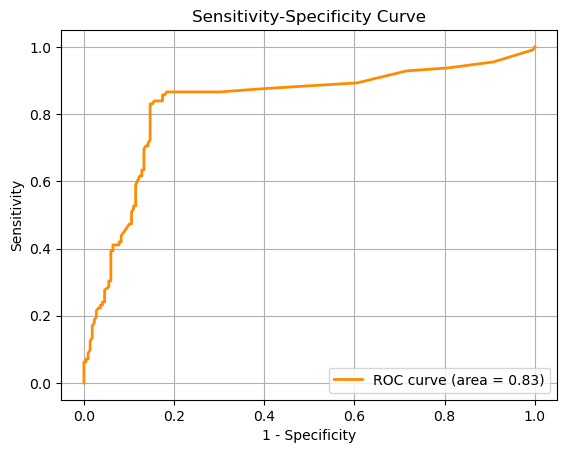

In [1167]:
# Concatenate the observed and predicted_proba lists across all folds
observed_all = np.concatenate(true_y)
predicted_proba_all = np.concatenate(pred_y)

# Compute ROC curve and AUC for the combined data
fpr, tpr, _ = roc_curve(observed_all, predicted_proba_all)
roc_auc_cnn = auc(fpr, tpr)

# Calculate sensitivity and specificity from the ROC curve data
sensitivity = tpr
specificity = 1 - fpr

# Plot sensitivity-specificity curve
plt.figure()
plt.plot(1 - specificity, sensitivity, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_cnn)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('Sensitivity-Specificity Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

##### Best concurrent sensitivity and specificity Youden's J Index

In [ ]:
# Calculate Youden's J statistic for each threshold
youden_j_values = np.array(sensitivity) + np.array(specificity) - 1
thresholds = np.arange(0.0, 1.01, 0.01)

# Find the index of the threshold that maximizes Youden's J value
best_threshold_index = np.argmax(youden_j_values)

# Get the corresponding threshold and its sensitivity and specificity values
best_threshold = thresholds[best_threshold_index]
best_sensitivity = sensitivity[best_threshold_index]
best_specificity = specificity[best_threshold_index]

# Desired specificity level
desired_specificity = 0.9

# Find the index in the specificity array that is closest to the desired specificity
closest_index = np.argmin(np.abs(specificity - desired_specificity))

# Get the corresponding sensitivity value at the closest index
sensitivity_at_desired_specificity = sensitivity[closest_index]

print(f"Sensitivity at {desired_specificity}% Specificity:", sensitivity_at_desired_specificity)

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best Sensitivity: {best_sensitivity:.4f}")
print(f"Best Specificity: {best_specificity:.4f}")

#### Pipeline - XGB Data Extraction all features

In [ ]:
# Create the pipeline
xgb_pipeline = Pipeline([
    ('conversion', DataConversion()),
    ('extract', TSFreshFeatureExtractor(default_fc_parameters="minimal", show_warnings=True)),
    ('cleandat', DataCleaner()),
    ('xgb', xgb.XGBClassifier())      
])
# Run pipeline
n_splits = 5
strat_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
roc_auc_scores = cross_validate(xgb_pipeline, xgb_dat, outcome, cv=strat_cv, scoring='roc_auc')

In [ ]:
roc_auc_scores['test_score'].mean()

0.6899206349206348

#### Plotting features - selected and extracted features

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


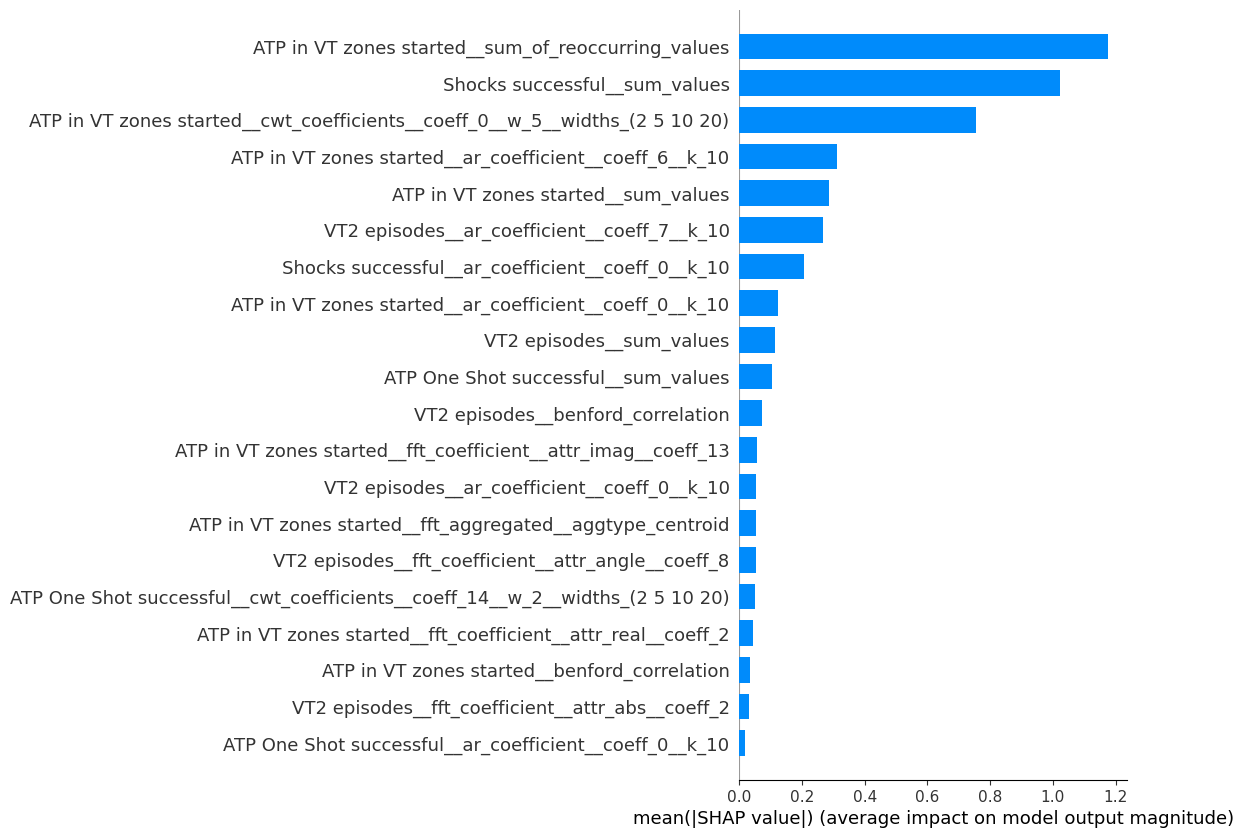

In [1671]:
# Loading JS visualization code to notebook
shap.initjs()
# Model is accessed from the manual run of the XGBoost model pipeline.
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_selected)
shap.summary_plot(shap_values, X_train_selected, plot_size=(5,10), plot_type="bar")